## Imports

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from ucimlrepo import fetch_ucirepo

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import xgboost as xgb


## Load the Dataset

In [67]:
adult = fetch_ucirepo(id=2) 

X = adult.data.features 
y = adult.data.targets 

df = X.join(y)

display(df)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


### Show data info


In [68]:
print(adult.metadata) 
  
print(adult.variables)

print(df.info())
print(df.shape)

print(df.columns[df.isnull().any()])

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

### Cleaning data


In [69]:
print(df.shape)

df = df.replace('?', pd.NA)
df = df.dropna()
print(df.shape)

df = df.drop_duplicates()
df = df.drop('education', axis=1)
print(df.shape)

(48842, 15)
(45222, 15)
(45194, 14)


## Binarize Target Variable

In [70]:
df['income'] = df['income'].replace('>50K.', '>50K')
df['income'] = df['income'].replace('<=50K.', '<=50K')

df['income'] = np.where(df['income'] == '>50K', 1, 0)
df.rename(columns={'income':'income>50K'}, inplace=True)

display(df['income>50K'])

print(df['income>50K'].value_counts()[0])

0        0
1        0
2        0
3        0
4        0
        ..
48836    0
48837    0
48839    0
48840    0
48841    1
Name: income>50K, Length: 45194, dtype: int32

33988


## Ordinal Encoding & One-Hot-Encoding

In [73]:
df3 = df.copy()
y3 = df3.iloc[:,-1:]
X3 = df3.iloc[:,1:-1]

encoder = LabelEncoder()
X3['sex'] = encoder.fit_transform(X3['sex'])

X3['marital-status'].replace(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 'Married', inplace=True)
X3['marital-status'].replace(['Divorced', 'Separated', 'Widowed'], 'Divorced', inplace=True)
X3 = pd.get_dummies(X3, columns=['marital-status'], dtype=int)

X3['workclass'].replace(['Self-emp-not-inc', 'Self-emp-inc'], 'self-emp', inplace=True)
X3['workclass'].replace(['Federal-gov', 'Local-gov', 'State-gov'], 'government', inplace=True)
X3['workclass'].replace(['Never-worked', 'Without-pay'], 'jobless', inplace=True)
X3 = pd.get_dummies(X3, columns=['workclass'], dtype=int)

X3['occupation'].replace(['Tech-support', 'Craft-repair', 'Machine-op-inspct'], 'Technical/Support', inplace=True)
X3['occupation'].replace(['Other-service', 'Priv-house-serv', 'Protective-serv'], 'Service', inplace=True)
X3['occupation'].replace(['Exec-managerial', 'Adm-clerical'], 'Management/Administration', inplace=True)
X3['occupation'].replace(['Sales'], 'Sales', inplace=True)
X3['occupation'].replace(['Prof-specialty'], 'Professional', inplace=True)
X3['occupation'].replace(['Handlers-cleaners', 'Farming-fishing', 'Transport-moving'], 'Manual Labor', inplace=True)
X3['occupation'].replace(['Armed-Forces'], 'Specialized', inplace=True)
X3 = pd.get_dummies(X3, columns=['occupation'], dtype=int)

X3['relationship'].replace(['Wife', 'Husband'], 'Spouse', inplace=True)
X3['relationship'].replace(['Own-child'], 'Child', inplace=True)
X3['relationship'].replace(['Other-relative'], 'Other Relatives', inplace=True)
X3['relationship'].replace(['Not-in-family', 'Unmarried'], 'Non-Family', inplace=True)
X3 = pd.get_dummies(X3, columns=['relationship'], dtype=int)

X3['race'].replace(['White'], 'White', inplace=True)
X3['race'].replace(['Asian-Pac-Islander'], 'Asian/Pacific Islander', inplace=True)
X3['race'].replace(['Amer-Indian-Eskimo'], 'American Indian/Eskimo', inplace=True)
X3['race'].replace(['Black'], 'Black', inplace=True)
X3['race'].replace(['Other'], 'Other', inplace=True)
X3 = pd.get_dummies(X3, columns=['race'], dtype=int)

X3['native-country'].replace(['United-States', 'Canada', 'Outlying-US(Guam-USVI-etc)'], 'North America', inplace=True)
X3['native-country'].replace(['England', 'Germany', 'Greece', 'Italy', 'Poland', 'Portugal', 'Ireland', 'France', 'Scotland', 'Yugoslavia', 'Hungary', 'Holand-Netherlands'], 'Europe', inplace=True)
X3['native-country'].replace(['Cambodia', 'India', 'Japan', 'China', 'Philippines', 'Vietnam', 'Taiwan', 'Laos', 'Iran', 'Thailand', 'Hong'], 'Asia', inplace=True)
X3['native-country'].replace(['Ecuador', 'Columbia', 'Peru','Puerto-Rico', 'Mexico', 'Cuba', 'Jamaica', 'Dominican-Republic', 'Haiti', 'Guatemala', 'Honduras', 'El-Salvador', 'Nicaragua', 'Trinadad&Tobago', 'Panama'], 'Central & South America', inplace=True)
X3 = pd.get_dummies(X3, columns=['native-country'], dtype=int)

display(X3.head())
print(X3.shape)


,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,marital-status_Divorced,marital-status_Married,marital-status_Never-married,workclass_Private,...,race_American Indian/Eskimo,race_Asian/Pacific Islander,race_Black,race_Other,race_White,native-country_Asia,native-country_Central & South America,native-country_Europe,native-country_North America,native-country_South
0,77516,13,1,2174,0,40,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,83311,13,1,0,0,13,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,215646,9,1,0,0,40,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,234721,7,1,0,0,40,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0
4,338409,13,0,0,0,40,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0


(45194, 34)


In [44]:
# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=1)

# Implementing Classifiers

### Originally, each classifier was implemented using Grid Search to find the best parameters.
### Below, we have shown the grid search technique for Logistic Regression
### However, the rest of the classifiers after that are implemented directly with the best parameters that were already found.

## Logistic Regression

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X3, np.ravel(y3), test_size=0.2, random_state=42)

# Create a pipeline that standardizes the data then creates a Logistic Regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),               # Feature scaling
    ('logreg', LogisticRegression(max_iter=1000))  # Logistic Regression classifier
])
# Define the parameter grid
param_grid = {
    'logreg__C': np.logspace(-4, 4, 20),               # Regularization strength
    'logreg__solver': ['liblinear', 'lbfgs'],  # Solvers
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Evaluate the best model found by GridSearchCV on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test set accuracy of the best model: ", test_accuracy)
y_pred = best_model.predict(X_test)

# Print Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get the coefficients of the features from the logistic regression model within the pipeline
feature_importances = best_model.named_steps['logreg'].coef_[0]

# Print feature names and their coefficients
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found:  {'logreg__C': 0.03359818286283781, 'logreg__solver': 'lbfgs'}
Best accuracy found:  0.8423454570598811
Test set accuracy of the best model:  0.841243500387211
Confusion Matrix:
[[6289  489]
 [ 946 1315]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6778
           1       0.73      0.58      0.65      2261

    accuracy                           0.84      9039
   macro avg       0.80      0.75      0.77      9039
weighted avg       0.83      0.84      0.83      9039

fnlwgt: 0.07002397422885559
education-num: 0.7254338698072164
sex: 0.1276384832558011
capital-gain: 2.1754006938641703
capital-loss: 0.2684565392554353
hours-per-week: 0.3260733592477665
marital-status_Divorced: -0.04393004210555545
marital-status_Married: 0.358928556150947
marital-status_Never-married: -0.3460746341580094
workclass_Private: 0.01017175889862

### Decision Tree 

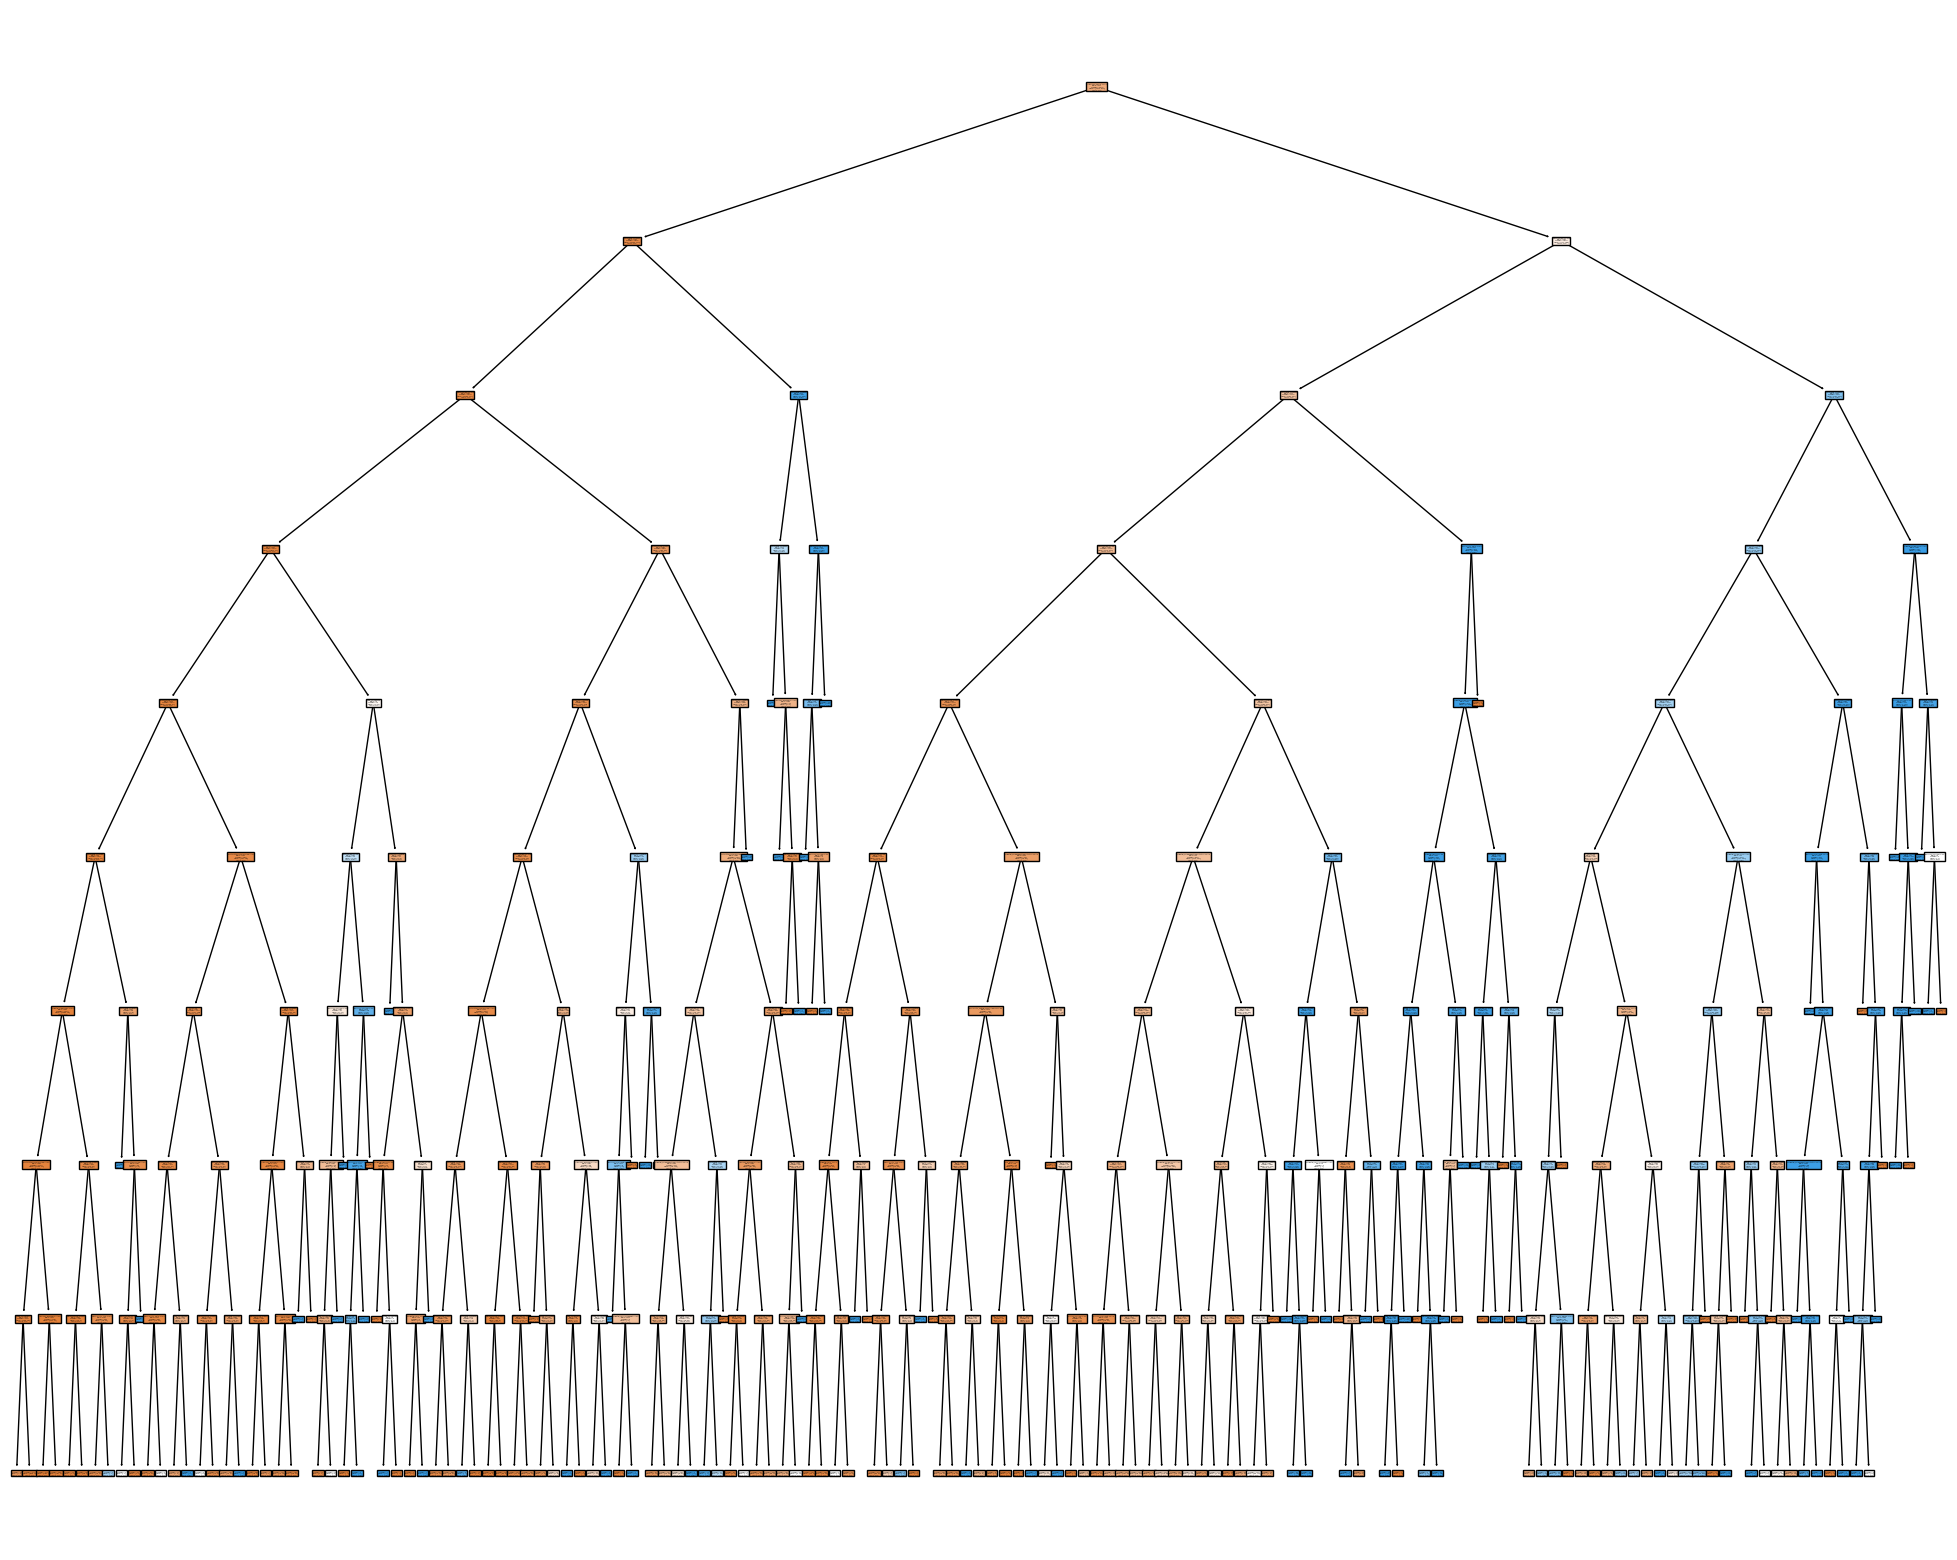

Accuracy: 0.8534129881624073

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      6778
           1       0.81      0.55      0.65      2261

    accuracy                           0.85      9039
   macro avg       0.83      0.75      0.78      9039
weighted avg       0.85      0.85      0.84      9039

Confusion Matrix:
[[6481  297]
 [1028 1233]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      6778
           1       0.81      0.55      0.65      2261

    accuracy                           0.85      9039
   macro avg       0.83      0.75      0.78      9039
weighted avg       0.85      0.85      0.84      9039

fnlwgt: 0.010975691324421397
education-num: 0.22250653237303103
sex: 0.005033766403371632
capital-gain: 0.20663398753102358
capital-loss: 0.07155109062472319
hours-per-week: 0.03191169491105483
marital-status_Divorced: 0.0
ma

In [74]:
clf = DecisionTreeClassifier(max_depth=9, random_state=1)
clf.fit(X_train, y_train)

fig = plt.figure(figsize=(25,20))
plot_tree(clf, 
                   feature_names=list(X_train.columns),  
                   class_names=['>50K', '<=50K'],
                   filled=True)
plt.show()

# Predict on the testing data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

feature_importances = clf.feature_importances_

# Print feature names and their importance scores
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

### K-nearest Neighbour


In [76]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=19)

# Train the KNN classifier
knn.fit(X_train_scaled, y_train)

# Predict on the testing data
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get feature names
feature_names = X3.columns

# Print the feature ranking with names
print("Feature ranking:")
for f in range(X_train_scaled.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, feature_names[f], feature_importances[f]))

Accuracy: 0.8284102223697312

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6778
           1       0.70      0.55      0.61      2261

    accuracy                           0.83      9039
   macro avg       0.78      0.73      0.75      9039
weighted avg       0.82      0.83      0.82      9039

Confusion Matrix:
[[6250  528]
 [1023 1238]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6778
           1       0.70      0.55      0.61      2261

    accuracy                           0.83      9039
   macro avg       0.78      0.73      0.75      9039
weighted avg       0.82      0.83      0.82      9039

Feature ranking:
1. Feature fnlwgt (0.010976)
2. Feature education-num (0.222507)
3. Feature sex (0.005034)
4. Feature capital-gain (0.206634)
5. Feature capital-loss (0.071551)
6. Feature hours-per-week (0.031912)
7. Feature

### Random Forest Classifier


In [78]:
# Create the model
model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees in the forest

# Train the model
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

importances = model.feature_importances_
feature_names = X_train.columns

# Create a dataframe to store feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top n most important features
n = 10  # Change this value to print more or fewer top features
print("Top", n, "most important features:")
print(feature_importance_df.head(n))

Accuracy: 0.824206217501936
Confusion Matrix:
[[6073  705]
 [ 884 1377]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      6778
           1       0.66      0.61      0.63      2261

    accuracy                           0.82      9039
   macro avg       0.77      0.75      0.76      9039
weighted avg       0.82      0.82      0.82      9039

Top 10 most important features:
                         Feature  Importance
0                         fnlwgt    0.336008
1                  education-num    0.114541
3                   capital-gain    0.109112
5                 hours-per-week    0.099495
23           relationship_Spouse    0.071375
7         marital-status_Married    0.056975
4                   capital-loss    0.038282
8   marital-status_Never-married    0.024027
21       relationship_Non-Family    0.015799
2                            sex    0.015647


### Neural Networks


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network architecture
model = Sequential()
model.add(Dense(units=320, input_dim=X_train_scaled.shape[1], activation='relu'))
for _ in range(1):
    model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')
y_pred = model.predict(X_test_scaled)
y_pred = np.where(y_pred > 0.5, 1, 0)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Epoch 1/10


1130/1130 [==============================] - 6s 5ms/step - loss: 0.3505 - accuracy: 0.8378 - val_loss: 0.3408 - val_accuracy: 0.8437
Epoch 2/10
1130/1130 [==============================] - 5s 4ms/step - loss: 0.3342 - accuracy: 0.8470 - val_loss: 0.3324 - val_accuracy: 0.8438
Epoch 3/10
1130/1130 [==============================] - 4s 4ms/step - loss: 0.3303 - accuracy: 0.8479 - val_loss: 0.3315 - val_accuracy: 0.8425
Epoch 4/10
1130/1130 [==============================] - 7s 6ms/step - loss: 0.3274 - accuracy: 0.8486 - val_loss: 0.3299 - val_accuracy: 0.8427
Epoch 5/10
1130/1130 [==============================] - 6s 5ms/step - loss: 0.3255 - accuracy: 0.8481 - val_loss: 0.3303 - val_accuracy: 0.8447
Epoch 6/10
1130/1130 [==============================] - 6s 5ms/step - loss: 0.3232 - accuracy: 0.8496 - val_loss: 0.3314 - val_accuracy: 0.8473
Epoch 7/10
1130/1130 [==============================] - 6s 5ms/step - loss: 0.3203 - accuracy: 0.8498 - val_loss: 0.3312 - val_accura

### Support Vector Machine

In [51]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initialize the Support Vector Machine model
model = SVC(kernel='linear')  # Using a linear kernel; you can try 'rbf' or others

# Train the model
model.fit(X_train_scaled, y_train)

# Predict on the testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

c:\Users\jason\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8433455028211085
Confusion Matrix:
[[6295  483]
 [ 933 1328]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6778
           1       0.73      0.59      0.65      2261

    accuracy                           0.84      9039
   macro avg       0.80      0.76      0.78      9039
weighted avg       0.84      0.84      0.84      9039



### XGBoost


In [52]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

# Convert the datasets to DMatrix, which is a high-performance XGBoost data structure
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify training parameters
params = {
    'max_depth': 3,  # Maximum depth of a tree
    'eta': 0.3,  # Learning rate
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',  # Evaluation metric for validation data
}
num_rounds = 100  # Number of boosting rounds

# Train the model
bst = xgb.train(params, dtrain, num_rounds)

# Predict on the testing set
y_pred_prob = bst.predict(dtest)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)  # Convert probabilities to binary output

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8643655271600841
Confusion Matrix:
[[6415  363]
 [ 863 1398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6778
           1       0.79      0.62      0.70      2261

    accuracy                           0.86      9039
   macro avg       0.84      0.78      0.80      9039
weighted avg       0.86      0.86      0.86      9039

